# 1.  Preprocessing

In [64]:
import cv2
import numpy as np
from PIL import Image
import pytesseract

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

# preprocess cascade
def preprocess_img(test_img_name):
    # read in color image
    test_img = cv2.imread(test_img_name)
    
    # convert to grayscale
    test_img = get_grayscale(test_img)
    
    # threshold
    test_img = cv2.threshold(255-test_img, 200, 220, cv2.THRESH_BINARY)[1]
    # test_img = remove_noise(test_img)
    # test_img = thresholding(test_img)
    return test_img


### use pytesseract to locate chars git repo --> https://github.com/madmaze/pytesseract/blob/master/tests/data/test.png ###
import string
all_valid_chars = list(string.ascii_lowercase + string.ascii_uppercase + string.digits)
def get_bounding_boxes(test_img):
    # get text
    img_text = pytesseract.image_to_string(test_img)
    
    # keep only alphanumeric characters in this string
    img_text_keeper = ''
    for t in img_text:
        if t in all_valid_chars:
            img_text_keeper += t
            
    # Get bounding box estimates
    bounding_boxes = pytesseract.image_to_boxes(test_img)

    # process bounding boxes
    bounding_boxes = bounding_boxes.split('\n')
    bounding_boxes = [v for v in bounding_boxes if len(v) > 0]
    bounding_box_entries = []
    for e in bounding_boxes:
        v = e.split(' ')
        entry = {}
        entry['character'] = v[0]
        entry['TL'] = v[1]
        entry['BL'] = v[2]
        entry['TR'] = v[3]
        entry['BR'] = v[4]
        bounding_box_entries.append(entry)
        
    # remove all non-alphanumeric characters
    bounding_box_keepers = []
    for e in bounding_box_entries:
        character = e['character']
        if character in all_valid_chars:
            bounding_box_keepers.append(e)

    return bounding_box_keepers, img_text_keeper

import cv2
import numpy as np
import matplotlib.pyplot as plt

def markup_detected_img(test_img_name):
    # preprocess img
    test_img = preprocess_img(test_img_name)
    
    # get bounding box entries
    bounding_box_entries, img_text = get_bounding_boxes(test_img)
    test_img = cv2.cvtColor(test_img.astype(np.uint8), cv2.COLOR_BGR2RGB)
    
    # compute median width - to split characters into string
    widths = []
    for v in bounding_box_entries:
        w = eval(v['TR']) - eval(v['TL'])
        widths.append(w)
    median_width = np.median(np.array(widths))

    # split detections into distinct words
    keeper_indices = []
    v = bounding_box_entries[0]
    TR = eval(v['TR'])
    TL = eval(v['TL'])
    all_words = []
    word = [v]
    for num in range(1,len(bounding_box_entries)):
        v = bounding_box_entries[num]
        TL = eval(v['TL'])
        if abs(TR - TL) <= 1.25*median_width:
            word.append(v)
        else:
            all_words.append(word)
            word = [v]
        TR = eval(v['TR'])
    if len(word) > 0:
        all_words.append(word)

    # filter out known problems
    all_words_filtered = []
    for word in all_words:
        if len(word) > 2:
            chars = ''.join([v['character'] for v in word])
            if chars != 'none':
                # keep word
                all_words_filtered.append(''.join([v['character'] for v in word]))         
                
                # paste on box
                for v in word:
                    x = eval(v['TL'])
                    y = test_img.shape[0] - eval(v['BL'])
                    h = eval(v['BR']) - eval(v['BL'])
                    w = eval(v['TR']) - eval(v['TL'])
                    character = v['character']

                    # print bounding box and label on img
                    test_img = cv2.rectangle(test_img, (x, y), (x + w, y - h), (255,0,0), 1)
                    test_img = cv2.putText(test_img, character, (x, y-30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)
        
        
    # plot marked up image
    fig = plt.figure(figsize=(10,10))
    im_array = np.asarray(test_img)
    plt.imshow(im_array)
    plt.show()
    
    # trim down filtered words
    all_words_filtered = [v for v in all_words_filtered if len(v) >= 5]
    return all_words_filtered

In [9]:
# load in image and very lightly preprocess
img_path = 'test_images'
img_name = 'easy_check.jpeg'
test_img_name = img_path + '/' + img_name
test_img = preprocess_img(test_img_name)

# use pytesseract to determine alphanumeric characters
bounding_box_entries, img_text = get_bounding_boxes(test_img)

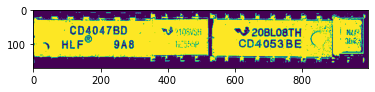

In [4]:
plt.imshow(test_img)
plt.show()

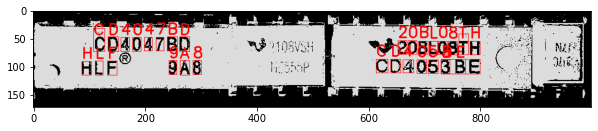

In [80]:
found_terms = markup_detected_img(test_img_name)

In [76]:
def create_url(code):
    url = 'https://www.alldatasheet.com/view.jsp?Searchword=' + str(code) + '&sField=4'
    return url

In [81]:
[create_url(v) for v in found_terms]

['https://www.alldatasheet.com/view.jsp?Searchword=CD4047BD&sField=4',
 'https://www.alldatasheet.com/view.jsp?Searchword=20BL08TH&sField=4',
 'https://www.alldatasheet.com/view.jsp?Searchword=CD4053BE&sField=4']